# Implementation of a PINN-based surrogate  for Model 1
In this notebook I implement a Physics Informed Neural Network (PINN) surrogate model for dynamics 1 and compare it against a neural network of a similar architecture.

# Initialization

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Generation and visualization

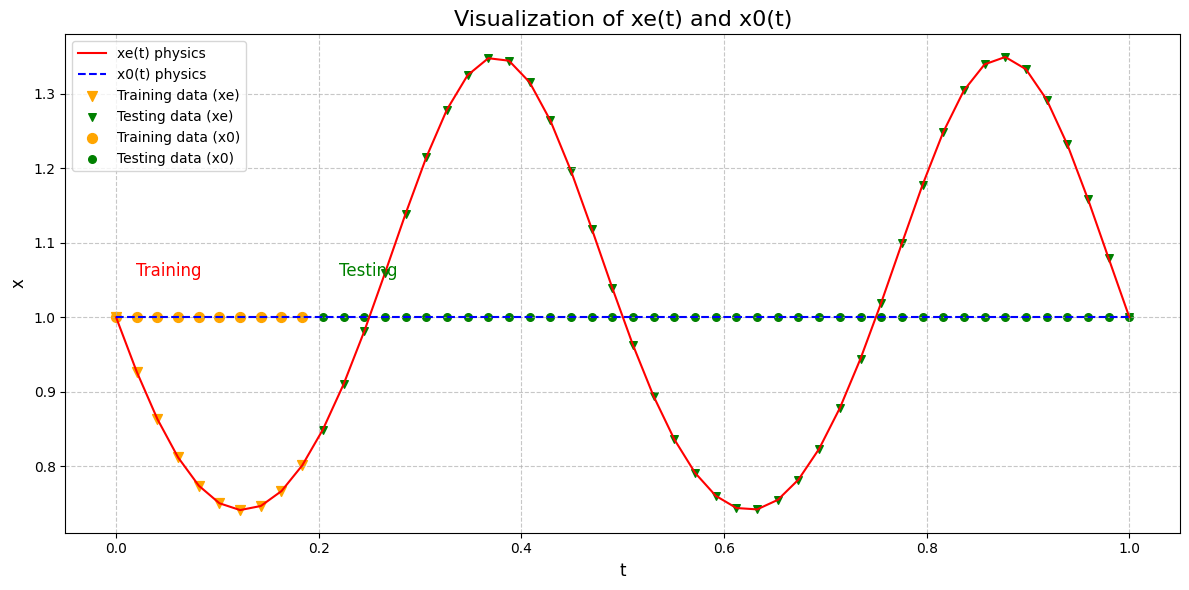

In [ ]:
# Define parameters
a = 0.5  # Period of the sine function
t = np.linspace(0, 1, 50)  # 50 points between 0 and 1

# Define functions
xe = lambda t: np.exp(-0.3 * np.sin(2 * np.pi * t / a))
x0 = lambda t: np.ones_like(t)

# Calculate function values
ye = xe(t)
y0 = x0(t)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot xe(t)
plt.plot(t, ye, 'r-', label='xe(t) physics')
# Plot x0(t)
plt.plot(t, y0, 'b--', label='x0(t) physics')
plt.scatter(t[:10], ye[:10],marker='v', color='orange', s=50, label='Training data (xe)')
plt.scatter(t[10:], ye[10:],marker='v', color='green', s=30, label='Testing data (xe)')


plt.scatter(t[:10], y0[:10], color='orange', s=50, label='Training data (x0)')
plt.scatter(t[10:], y0[10:], color='green', s=30, label='Testing data (x0)')

# Customize the plot
plt.title('Visualization of xe(t) and x0(t)', fontsize=16)
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Add text annotations
plt.text(0.02, 1.05, 'Training', color='red', fontsize=12, ha='left', va='bottom')
plt.text(0.22, 1.05, 'Testing', color='green', fontsize=12, ha='left', va='bottom')

plt.tight_layout()
plt.show()

# Simple NN performance

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4599
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4464
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4330
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4199
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.4069
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3941
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.3814
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3690
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3566
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3444
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3324
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3205
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3087
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2970
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2854
Epoch 16/500
1/1 ━━━━

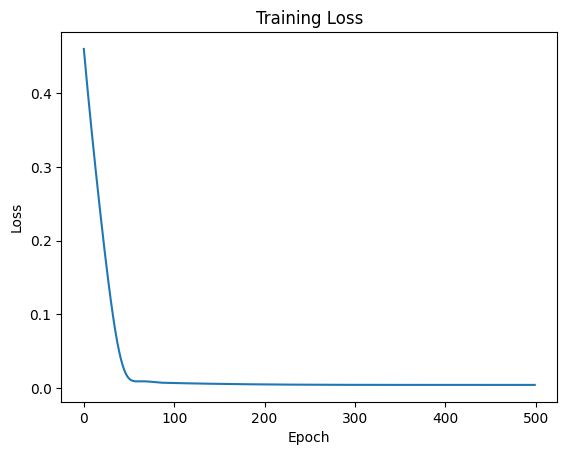

In [ ]:
# Sparse dataset
t_data = np.linspace(0, 1, 50).reshape(-1, 1)  # 30 points for t
x0_data = np.ones_like(t_data)  # x0 remains constant at 1
xe_data = np.exp(-0.3*np.sin(2 * np.pi * t_data/0.3))  # example sparse data for xe based on assumed solution
s=10
# Split the dataset: First 25 points for training, last 5 points for testing
t_train, t_test = t_data[:s], t_data[s:]
x0_train, x0_test = x0_data[:s], x0_data[s:]
xe_train, xe_test = xe_data[:s], xe_data[s:]
# Create a simple neural network model
class SimpleNNModel(tf.keras.Model):
    def __init__(self):
        super(SimpleNNModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(32, activation='tanh')
        self.out = tf.keras.layers.Dense(2)  # Two outputs: x0 and xe

    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        return self.out(x)  # Returns [x0_pred, xe_pred]

# Instantiate the model
model = SimpleNNModel()

# Compile the model using MSE loss and an optimizer
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta=1.0))

# Prepare training data
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
x0_train_tensor = tf.convert_to_tensor(x0_train, dtype=tf.float32)
xe_train_tensor = tf.convert_to_tensor(xe_train, dtype=tf.float32)

y_train_data = tf.concat([x0_train_tensor, xe_train_tensor], axis=1)  # Combine x0 and xe data for training

# Train the model
history = model.fit(t_train_tensor, y_train_data, epochs=500, verbose=1)

# Plot the training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


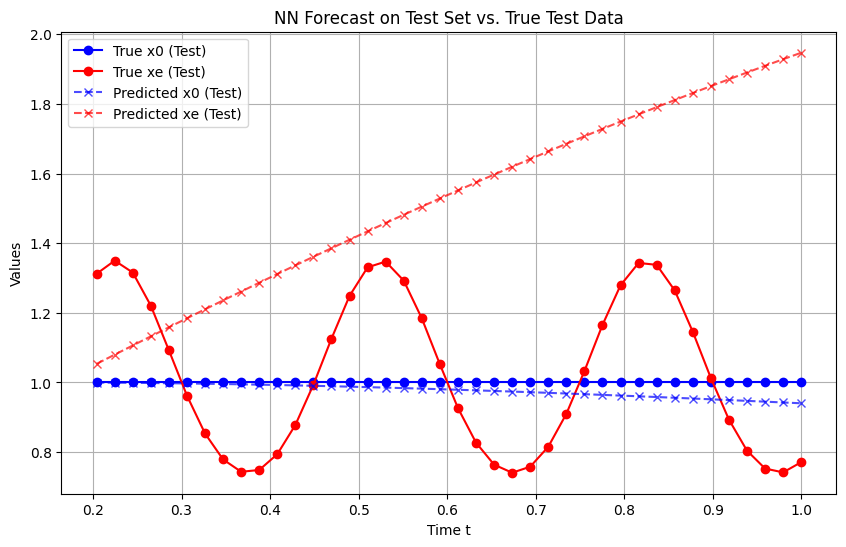

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on the test set
t_test_tensor = tf.convert_to_tensor(t_test, dtype=tf.float32)
predictions = model(t_test_tensor)
x0_pred, xe_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

# True test values
x0_true_test = x0_test.flatten()
xe_true_test = xe_test.flatten()

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot true test data
plt.plot(t_test, x0_true_test, 'bo-', label='True x0 (Test)')
plt.plot(t_test, xe_true_test, 'ro-', label='True xe (Test)')

# Plot predicted data
plt.plot(t_test, x0_pred, 'bx--', label='Predicted x0 (Test)', alpha=0.7)
plt.plot(t_test, xe_pred, 'rx--', label='Predicted xe (Test)', alpha=0.7)

# Labels and title
plt.xlabel('Time t')
plt.ylabel('Values')
plt.title('NN Forecast on Test Set vs. True Test Data')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# True values for x0 and xe
x0_test_true = x0_test.flatten()
xe_test_true = xe_test.flatten()

# Mean Absolute Error (MAE)
mae_x0 = mean_absolute_error(x0_test_true, x0_pred)
mae_xe = mean_absolute_error(xe_test_true, xe_pred)

# Mean Squared Error (MSE)
mse_x0 = mean_squared_error(x0_test_true, x0_pred)
mse_xe = mean_squared_error(xe_test_true, xe_pred)

print(f"Mean Absolute Error (x0): {mae_x0}")
print(f"Mean Absolute Error (xe): {mae_xe}")
print(f"Mean Squared Error (x0): {mse_x0}")
print(f"Mean Squared Error (xe): {mse_xe}")


Mean Absolute Error (x0): 0.023532603681087495
Mean Absolute Error (xe): 0.544306574121529
Mean Squared Error (x0): 0.0008878833015844911
Mean Squared Error (xe): 0.39634427035138575


# PINNs Performance

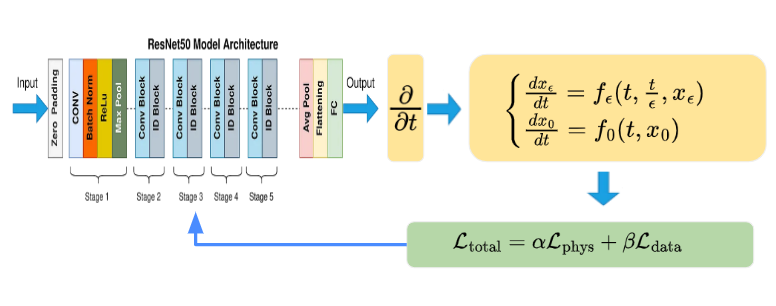

In [ ]:
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, units):
        super(ResNetBlock, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(units, activation=None)  # No activation for the second layer

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x + inputs  # Residual connection

# Using physics for data enhancement
# Sparse dataset
s=5000
# Generate the first segment of the time vector
t1 = np.linspace(0, 1, s)

# Generate the second segment of the time vector
t2 = np.linspace(0.2, 1, 40)

# Concatenate the two segments
t_data = np.concatenate((t1, t2)).reshape(-1, 1)
x0_data = np.ones_like(t_data)  # x0 remains constant at 1
xe_data = np.exp(-0.3*np.sin(2 * np.pi * t_data/0.3))  # example sparse data for xe based on assumed solution

# Split the dataset: First 25 points for training, last 5 points for testing
t_train, t_test = t_data[:s], t_data[s:]
x0_train, x0_test = x0_data[:s], x0_data[s:]
xe_train, xe_test = xe_data[:s], xe_data[s:]
# Physics constants
a = 0.3  # Adjust `a` as needed

# Define the neural network model
# Define the ResNet-based PINN model
class ResNetPINNModel(tf.keras.Model):
    def __init__(self, num_blocks, units):
        super(ResNetPINNModel, self).__init__()
        self.input_layer = tf.keras.layers.Dense(units, activation='tanh')
        self.res_blocks = [ResNetBlock(units) for _ in range(num_blocks)]
        self.output_layer = tf.keras.layers.Dense(2)  # Two outputs: x0 and xe

    def call(self, t):
        x = self.input_layer(t)
        for block in self.res_blocks:
            x = block(x)
        return self.output_layer(x)  # Returns [x0_pred, xe_pred]




num_blocks = 10  # Adjust the number of ResNet blocks
units = 20      # Number of units per layer
model = ResNetPINNModel(num_blocks=num_blocks, units=units)

# Define the loss function (combining data-driven and physics-informed losses)
huber_loss = tf.keras.losses.Huber(delta=1.0)
#_____________________________________________________________________________
@tf.function
def physics_loss(model, t, x0_true, xe_true):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        pred = model(t)
        x0_pred = pred[:, 0:1]
        xe_pred = pred[:, 1:2]

    # Compute the gradients (time derivatives)
    dx0_dt = tape.gradient(x0_pred, t)
    dxe_dt = tape.gradient(xe_pred, t)
    del tape

    # Data-driven losses
    loss_x0 = huber_loss(x0_true, x0_pred)
    loss_xe = huber_loss(xe_true, xe_pred)

    # Physics-informed losses
    physics_x0_loss = huber_loss(0.0, dx0_dt)  # dx0/dt should be 0
    physics_xe_loss = huber_loss(-xe_pred * tf.cos((2 * np.pi * t) / a), dxe_dt)  # Physics constraint on dxe/dt

    # Weighted total loss
    total_loss = 0.5*(0.5*loss_x0 + 0.5*physics_x0_loss)  + 0.5*(0.5*loss_xe + 0.5*physics_xe_loss)
    return total_loss
#_____________________________________________________________________________

# Compile the model (no optimizer here as we will implement a custom training loop)
optimizer = tf.keras.optimizers.Adam()

# Training loop
def train_step(model, t, x0_true, xe_true):
    with tf.GradientTape() as tape:
        loss = physics_loss(model, t, x0_true, xe_true)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# Prepare training data
t_train_tensor = tf.convert_to_tensor(t_train, dtype=tf.float32)
x0_train_tensor = tf.convert_to_tensor(x0_train, dtype=tf.float32)
xe_train_tensor = tf.convert_to_tensor(xe_train, dtype=tf.float32)
# Training parameters
epochs = 1500  # Adjust based on convergence
for epoch in range(epochs):
    loss_value = train_step(model, t_train_tensor, x0_train_tensor, xe_train_tensor)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

# Once trained, the model will have learned both the data and the physics constraints.


Epoch 0, Loss: 1.1236246824264526
Epoch 100, Loss: 0.04256114736199379
Epoch 200, Loss: 0.040076445788145065
Epoch 300, Loss: 0.03802235797047615
Epoch 400, Loss: 0.029139835387468338
Epoch 500, Loss: 0.08556799590587616
Epoch 600, Loss: 0.010525356978178024
Epoch 700, Loss: 0.005257930140942335
Epoch 800, Loss: 0.004240129608660936
Epoch 900, Loss: 0.00412115640938282
Epoch 1000, Loss: 0.004119044169783592
Epoch 1100, Loss: 0.004225733689963818
Epoch 1200, Loss: 0.004299820866435766
Epoch 1300, Loss: 0.004573340993374586
Epoch 1400, Loss: 0.004135719034820795


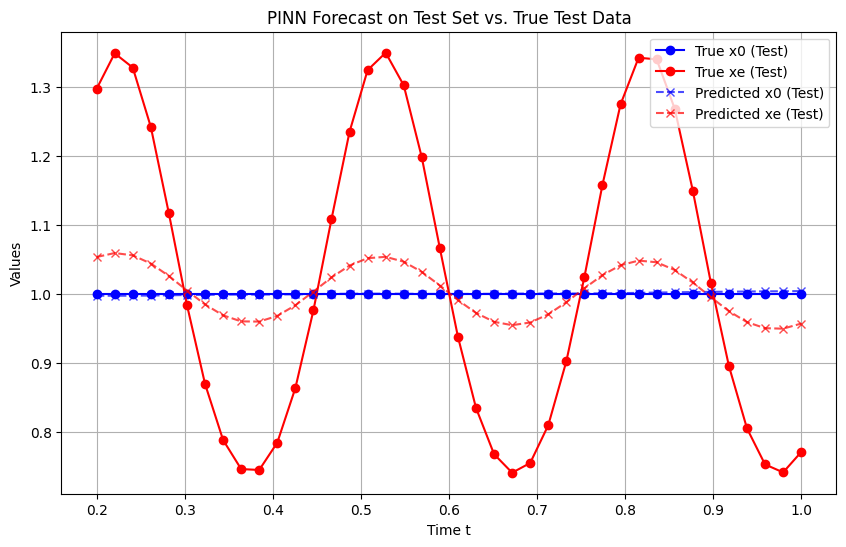

In [ ]:
# Make predictions on the test set
t_test_tensor = tf.convert_to_tensor(t_test, dtype=tf.float32)
predictions = model(t_test_tensor)
x0_pred, xe_pred = predictions[:, 0].numpy(), predictions[:, 1].numpy()

# True test values
x0_true_test = x0_test.flatten()
xe_true_test = xe_test.flatten()

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot true test data
plt.plot(t_test, x0_true_test, 'bo-', label='True x0 (Test)')
plt.plot(t_test, xe_true_test, 'ro-', label='True xe (Test)')

# Plot predicted data
plt.plot(t_test, x0_pred, 'bx--', label='Predicted x0 (Test)', alpha=0.7)
plt.plot(t_test, xe_pred, 'rx--', label='Predicted xe (Test)', alpha=0.7)

# Labels and title
plt.xlabel('Time t')
plt.ylabel('Values')
plt.title('PINN Forecast on Test Set vs. True Test Data')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# True values for x0 and xe
x0_test_true = x0_test.flatten()
xe_test_true = xe_test.flatten()

# Mean Absolute Error (MAE)
mae_x0 = mean_absolute_error(x0_test_true, x0_pred)
mae_xe = mean_absolute_error(xe_test_true, xe_pred)

# Mean Squared Error (MSE)
mse_x0 = mean_squared_error(x0_test_true, x0_pred)
mse_xe = mean_squared_error(xe_test_true, xe_pred)

print(f"Mean Absolute Error (x0): {mae_x0}")
print(f"Mean Absolute Error (xe): {mae_xe}")
print(f"Mean Squared Error (x0): {mse_x0}")
print(f"Mean Squared Error (xe): {mse_xe}")


Mean Absolute Error (x0): 0.0013886824250221252
Mean Absolute Error (xe): 0.16772536254625478
Mean Squared Error (x0): 3.4286844077691116e-06
Mean Squared Error (xe): 0.034818265983910544
